In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [64]:
df = pd.read_csv('model/student_habits_performance.csv')

In [65]:
df.head()

,student_id,age,gender,study_hours_per_day,social_media_hours,netflix_hours,part_time_job,attendance_percentage,sleep_hours,diet_quality,exercise_frequency,parental_education_level,internet_quality,mental_health_rating,extracurricular_participation,exam_score
0,S1000,23,Female,0.0,1.2,1.1,No,85.0,8.0,Fair,6,Master,Average,8,Yes,56.2
1,S1001,20,Female,6.9,2.8,2.3,No,97.3,4.6,Good,6,High School,Average,8,No,100.0
2,S1002,21,Male,1.4,3.1,1.3,No,94.8,8.0,Poor,1,High School,Poor,1,No,34.3
3,S1003,23,Female,1.0,3.9,1.0,No,71.0,9.2,Poor,4,Master,Good,1,Yes,26.8
4,S1004,19,Female,5.0,4.4,0.5,No,90.9,4.9,Fair,3,Master,Good,1,No,66.4


In [66]:
df.shape

(1000, 16)

### Univariate Analysis

In [67]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='object').columns.tolist()

In [68]:
print("\n🔹 Numerical Columns:", num_cols)
print("🔹 Categorical Columns:", cat_cols)


🔹 Numerical Columns: ['age', 'study_hours_per_day', 'social_media_hours', 'netflix_hours', 'attendance_percentage', 'sleep_hours', 'exercise_frequency', 'mental_health_rating', 'exam_score']
🔹 Categorical Columns: ['student_id', 'gender', 'part_time_job', 'diet_quality', 'parental_education_level', 'internet_quality', 'extracurricular_participation']


In [69]:
fig = px.scatter_3d(
    df,
    x='study_hours_per_day',
    y='sleep_hours',
    z='exam_score',
    color='mental_health_rating',
    size='attendance_percentage',
    hover_data=['diet_quality', 'exercise_frequency'],
    title='🎓 How Lifestyle Habits Affect Exam Performance',
)
fig.update_layout(
    template='plotly_dark',
    title_font=dict(size=20, color='white'),
    scene=dict(
        xaxis_title='Study Hours per Day',
        yaxis_title='Sleep Hours',
        zaxis_title='Exam Score'
    )
)
fig.show()

In [92]:
fig = px.imshow(
    df[num_cols].corr(),
    text_auto=".2f",
    color_continuous_scale='RdBu_r',
    title='🔥 Correlation Heatmap Between Study Habits and Exam Performance',
    height= 1024,
    width= 1024
)
fig.update_layout(
    template='plotly_dark',
    title_font=dict(size=18, color='white')
)
fig.show()


In [71]:
print(df.shape)
df2 = df[:int(df.shape[0]/5)]
print(df2.shape)

(1000, 16)
(200, 16)


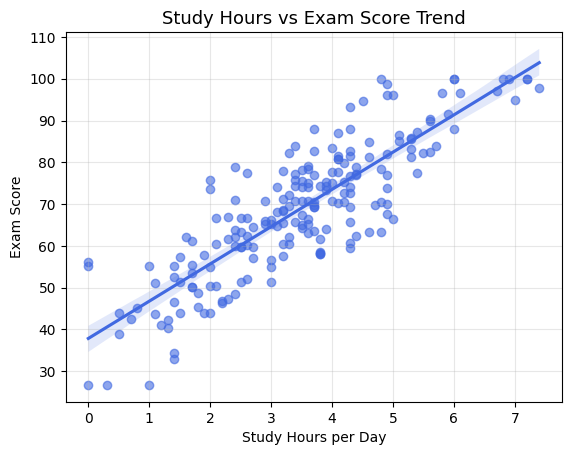

In [72]:
sns.regplot(x=df2['study_hours_per_day'], y=df2['exam_score'], color='royalblue', scatter_kws={'alpha':0.6})
plt.title('Study Hours vs Exam Score Trend', fontsize=13)
plt.xlabel('Study Hours per Day')
plt.ylabel('Exam Score')
plt.grid(alpha=0.3)
plt.show()


In [73]:
target = df['exam_score']

In [74]:
target_column_name = 'exam_score'
if target_column_name in df.columns:
    print(f"\n🔹 Target column selected: {target_column_name}")


🔹 Target column selected: exam_score


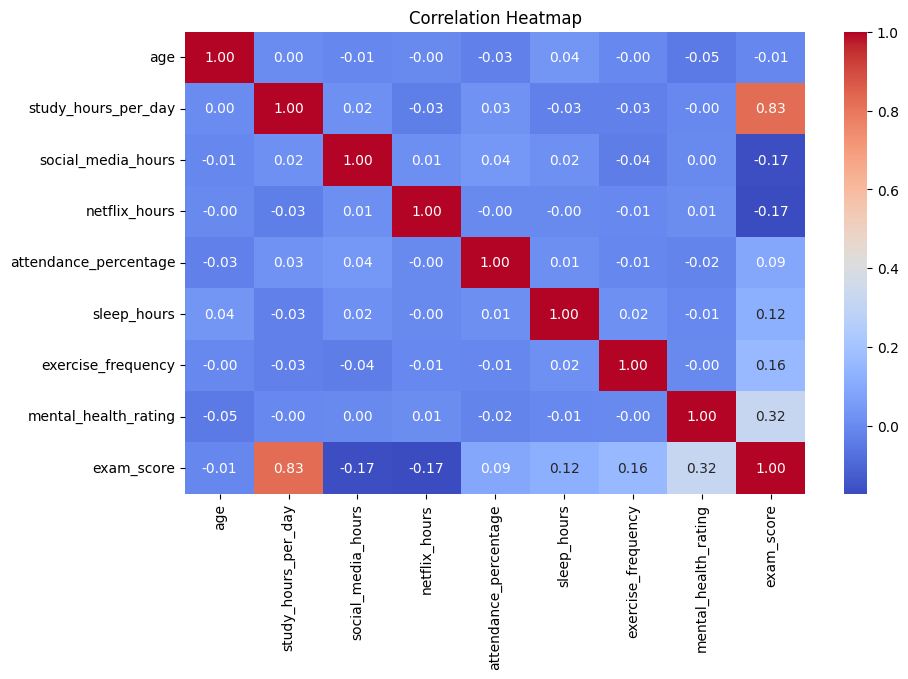

In [76]:
if len(num_cols) > 1:
  plt.figure(figsize=(10,6))
  corr = df[num_cols].corr()
  sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
  plt.title("Correlation Heatmap")
  plt.show()

In [77]:
for col in num_cols:
    fig = px.box(
        df,
        x=col,
        points='all',  # shows all outliers
        title=f'Outlier Visualization: {col}',
        color_discrete_sequence=['#00CC96']
    )
    fig.update_layout(template='plotly_dark')
    fig.show()

In [78]:
df.drop(columns=['student_id'], inplace=True)

In [79]:
df_encoded = pd.get_dummies(df, drop_first=True)

In [96]:
df_encoded.head()

,age,study_hours_per_day,social_media_hours,netflix_hours,attendance_percentage,sleep_hours,exercise_frequency,mental_health_rating,exam_score,gender_Male,gender_Other,part_time_job_Yes,diet_quality_Good,diet_quality_Poor,parental_education_level_High School,parental_education_level_Master,internet_quality_Good,internet_quality_Poor,extracurricular_participation_Yes
0,23,0.0,1.2,1.1,85.0,8.0,6,8,56.2,False,False,False,False,False,False,True,False,False,True
1,20,6.9,2.8,2.3,97.3,4.6,6,8,100.0,False,False,False,True,False,True,False,False,False,False
2,21,1.4,3.1,1.3,94.8,8.0,1,1,34.3,True,False,False,False,True,True,False,False,True,False
3,23,1.0,3.9,1.0,71.0,9.2,4,1,26.8,False,False,False,False,True,False,True,True,False,True
4,19,5.0,4.4,0.5,90.9,4.9,3,1,66.4,False,False,False,False,False,False,True,True,False,False


In [97]:
X = df_encoded.drop(columns=['exam_score'])
y = df_encoded['exam_score']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=69),
    'Lasso': Lasso(random_state=69),
    'RandomForest': RandomForestRegressor(n_estimators=200, random_state=69, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(n_estimators=200, random_state=69),
    'XGBoost': XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1)
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define models
models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(random_state=69),
    'Lasso': Lasso(random_state=69),
    'RandomForest': RandomForestRegressor(random_state=69, n_jobs=-1),
    'GradientBoosting': GradientBoostingRegressor(random_state=69),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=69)
}

# Define parameter grids
param_grids = {
    'LinearRegression': {'fit_intercept': [True, False]},
    'Ridge': {'alpha': [0.01, 0.1, 1, 10, 100], 'solver': ['auto', 'saga', 'lbfgs']},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1, 10], 'max_iter': [1000, 5000, 10000]},
    'RandomForest': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'GradientBoosting': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]},
    'XGBoost': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5],
                'subsample': [0.8, 1], 'colsample_bytree': [0.8, 1]}
}

# Tune hyperparameters
best_models = {}
for name, model in models.items():
    print(f"\n🔍 Tuning {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_scaled, y_train)  # use scaled data if applicable
    print(f"✅ Best params for {name}: {grid_search.best_params_}")
    print(f"📈 Best R² score: {grid_search.best_score_:.4f}")
    best_models[name] = grid_search.best_estimator_

# Evaluate tuned models
results = {}
for name, model in best_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {'MAE': mae, 'RMSE': rmse, 'R2': r2}

# Display sorted results
results_df = pd.DataFrame(results).T.sort_values(by='R2', ascending=False)
print("\n🏆 Final Model Performance (after tuning):")
print(results_df)


🔍 Tuning LinearRegression...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
✅ Best params for LinearRegression: {'fit_intercept': True}
📈 Best R² score: 0.8950

🔍 Tuning Ridge...
Fitting 5 folds for each of 15 candidates, totalling 75 fits


e:\Student_Habit_Performance\myenv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning:


25 fits failed out of a total of 75.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "e:\Student_Habit_Performance\myenv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "e:\Student_Habit_Performance\myenv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "e:\Student_Habit_Performance\myenv\Lib\site-packages\sklearn\linear_model\_ridge

✅ Best params for Ridge: {'alpha': 1, 'solver': 'saga'}
📈 Best R² score: 0.8951

🔍 Tuning Lasso...
Fitting 5 folds for each of 15 candidates, totalling 75 fits
✅ Best params for Lasso: {'alpha': 0.1, 'max_iter': 1000}
📈 Best R² score: 0.8956

🔍 Tuning RandomForest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best params for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
📈 Best R² score: 0.8496

🔍 Tuning GradientBoosting...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Best params for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300}
📈 Best R² score: 0.8767

🔍 Tuning XGBoost...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
✅ Best params for XGBoost: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
📈 Best R² score: 0.8850

🏆 Final Model Performance (after tuning):
                       MAE      RMSE        R2
Lasso   

In [109]:
# model = LinearRegression()
# model.fit(X_train_scaled, y_train)
# y_pred = model.predict(X_test_scaled)
joblib.dump(model, 'exam_score_model.pkl')

['exam_score_model.pkl']

In [110]:
joblib.dump(scaler, 'scaler.pkl')
scaler = joblib.load('scaler.pkl')

In [111]:
loaded_model = joblib.load('exam_score_model.pkl')

In [112]:
y_pred = loaded_model.predict(X_test_scaled)

print("R² Score:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

R² Score: 0.8852481741135585
MAE: 4.468390489578248
